# Q1

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://test.pypi.org/simple/


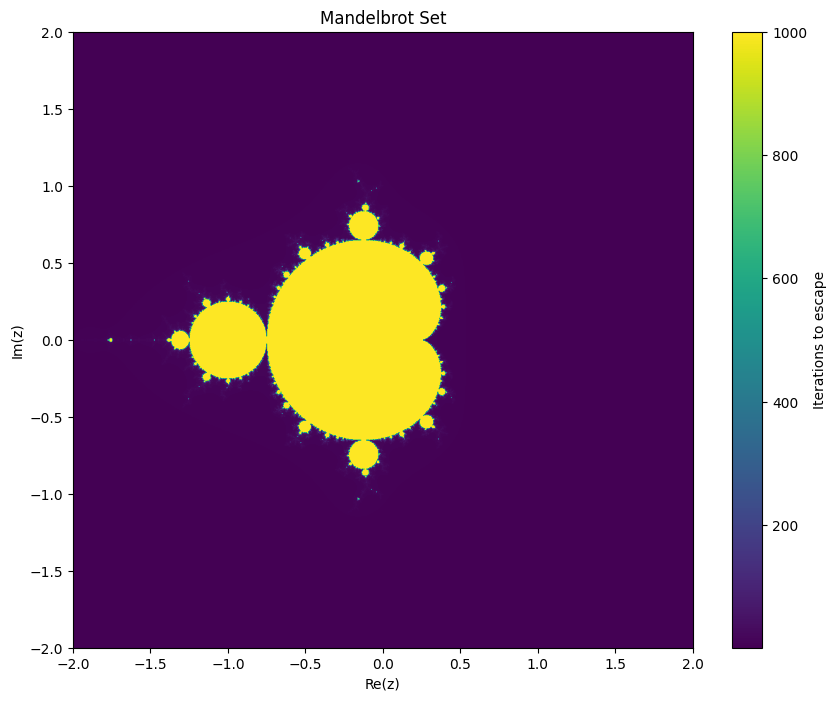

In [1]:
import subprocess
import sys

# Step 1: Install the package from TestPyPI
subprocess.check_call([
    sys.executable, "-m", "pip", "install",  # Use sys.executable to ensure correct pip version
    "--index-url", "https://test.pypi.org/simple/",
    "mandelbrot_plot"
])

# Step 2: Import your module
import mandelbrot_plot

# Step 3: Use it to plot
mandelbrot_plot.plot()  # Call the 'plot' function from mandelbrot_plot.py to generate the Mandelbrot plot


# Q4

# modules

In [2]:
import random
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import trange
from numba import njit


# idea: simulatea a ball falling through a series of pegs

## Ball class

In [3]:
# Class representing the Ball
class Ball:
    def __init__(self, radius, x, y, vx, vy):
        # Ball parameters
        self.radius = radius
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy

    # Getter and Setter for the position
    def get_position(self):
        return self.x, self.y

    def set_position(self, x, y):
        self.x = x
        self.y = y

    # Getter and Setter for velocity
    def get_velocity(self):
        return self.vx, self.vy

    def set_velocity(self, vx, vy):
        self.vx = vx
        self.vy = vy

    # Function to update ball's position
    def update_trajectory(self, dt, g):
        self.x += self.vx * dt
        self.y += self.vy * dt

        self.vy -= g * dt


## Board with pegs class

In [4]:
# Class representing the Board (Pegboard)
class Board:
    def __init__(self, rows, cols, peg_spacing_x, peg_spacing_y, g):
        # Board parameters
        self.g = g  # gravity constant [m/s^2]
        self.rows = rows  # number of rows of pegs
        self.cols = cols  # number of columns of pegs
        self.peg_spacing_x = peg_spacing_x  # distance between pegs in x
        self.peg_spacing_y = peg_spacing_y  # distance between pegs in y
        self.pegs = self.generate_pegs()

    # Function to generate peg positions (2D grid of pegs)
    def generate_pegs(self):
        pegs = []
        #for row in range(-self.rows // 2, self.rows // 2 + 1):
        for row in range(self.rows):
            offset_x = 0
            if row % 2 != 0:  # Apply offset for every odd row
                offset_x = self.peg_spacing_x / 2

            for col in range(-self.cols // 2, self.cols // 2 + 1):
                peg_x = col * self.peg_spacing_x + offset_x
                peg_y = row * self.peg_spacing_y
                pegs.append((peg_x, peg_y))
        return pegs

    # Function to detect collision between the ball and any peg
    def detect_collision(self, ball):
        ball_x, ball_y = ball.get_position()
        ball_radius = ball.radius
        for peg_x, peg_y in self.pegs:
            # Check if the distance from the ball's center to the peg is less than the sum of the radii
            distance = math.sqrt((ball_x - peg_x)**2 + (ball_y - peg_y)**2)
            if distance <= ball_radius:
                return peg_x, peg_y  # Collision detected with a peg
        return None


    # Function to handle the ball's momentum change upon collision with damping and angular spread
    def change_momentum(self, ball, peg_x, peg_y):
        # Damping factor for velocity reduction after collision
        damping_factor = 0.9
        # Maximum angular spread in degrees (+/-)
        max_angle_deg = 5  

        # Get the ball's current velocity and position
        ball_x, ball_y = ball.get_position()
        ball_vx, ball_vy = ball.get_velocity()

        # Calculate the direction of the peg to the ball's center
        dx = ball_x - peg_x
        dy = ball_y - peg_y
        norm = math.sqrt(dx**2 + dy**2)
        unit_dx = dx / norm
        unit_dy = dy / norm

        # Calculate the relative velocity (dot product) along the peg-ball line
        velocity_along_line = ball_vx * unit_dx + ball_vy * unit_dy

        # Reflect the velocity to simulate an elastic collision (perfect reflection)
        if velocity_along_line < 0:
            ball_vx -= 2 * velocity_along_line * unit_dx
            ball_vy -= 2 * velocity_along_line * unit_dy

            # Apply damping
            ball_vx *= damping_factor
            ball_vy *= damping_factor

            # Add angular spread (random small rotation)
            angle_rad = math.radians(random.uniform(-max_angle_deg, max_angle_deg))
            cos_theta = math.cos(angle_rad)
            sin_theta = math.sin(angle_rad)

            new_vx = ball_vx * cos_theta - ball_vy * sin_theta
            new_vy = ball_vx * sin_theta + ball_vy * cos_theta

            ball.set_velocity(new_vx, new_vy)

    # Function to check if the ball has hit the ground
    def has_hit_ground(self, ball):
        _, ball_y = ball.get_position()
        return ball_y <= 0  # Ball has reached the ground if y <= 0


    def is_out_of_bounds(self, ball):
        ball_x, _ = ball.get_position()
        x_min = -self.cols / 2 * self.peg_spacing_x
        x_max = self.cols / 2 * self.peg_spacing_x
        return ball_x < x_min or ball_x > x_max


## board general variables

In [5]:
radius = 1  # radius of the ball
vx = 0  # initial velocity in the x direction
vy = 0  # initial velocity in the y direction
g = 4.5  # gravity (m/s^2)
dt = 0.01  # time step (in seconds)
rows = 40  # number of rows of pegs
cols = 80  # number of columns of pegs
peg_spacing_x = 5  # horizontal spacing between pegs [mm]
peg_spacing_y = 5  # vertical spacing between pegs [mm]
x = 0  # initial x position of the ball
y = (rows+1)*peg_spacing_y  # initial y position of the ball

## runs a single simulation plotting the trajectory (crosscheck)

In [6]:
def run_simulation():
    # Initialize the board and ball
    board = Board(rows, cols, peg_spacing_x, peg_spacing_y, g)
    ball = Ball(radius, x, y, vx, vy)

    # List to store the trajectory of the ball
    trajectory = []

    # Simulation loop
    while not board.has_hit_ground(ball):
        # Update ball's position and apply gravity
        ball.update_trajectory(dt, g)

        # Detect collision with pegs
        collision = board.detect_collision(ball)
        if collision:
            peg_x, peg_y = collision
            board.change_momentum(ball, peg_x, peg_y)

        # Save current position
        trajectory.append(ball.get_position())

    # Extract positions for plotting
    traj_xs = [pos[0] for pos in trajectory]
    traj_ys = [pos[1] for pos in trajectory]

    # Plot pegs and trajectory
    pegs = board.pegs
    peg_xs = [peg[0] for peg in pegs]
    peg_ys = [peg[1] for peg in pegs]

    plt.figure(figsize=(8, 8))

    # Plot pegs as small dots
    plt.scatter(peg_xs, peg_ys, c='blue', s=2, label='Pegs')

    # Plot trajectory as dots with size proportional to ball radius
    marker_size = (radius * 10)**2
    plt.scatter(traj_xs, traj_ys, s=2.5, c='red', alpha=0.8, label='Ball trajectory')

    plt.title("Ball trajectory through Pegboard")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.grid(True)

    # Avoid duplicate legend entries
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.show()


## runs multiple simulation histogramming the abscissa of arrival

In [7]:
def run_multiple_simulations(n):

    final_x_positions = []
    all_trajectories = []

    for _ in trange(n, desc="Simulating"):
        board = Board(rows, cols, peg_spacing_x, peg_spacing_y, g)
        ball = Ball(radius, x, y, vx, vy)
        trajectory = []

        valid_trajectory = True

        while not board.has_hit_ground(ball):
            ball.update_trajectory(dt, g)

            if board.is_out_of_bounds(ball):
                valid_trajectory = False
                break

            collision = board.detect_collision(ball)
            if collision:
                peg_x, peg_y = collision
                board.change_momentum(ball, peg_x, peg_y)

            trajectory.append(ball.get_position())

        if valid_trajectory:
            final_x, _ = ball.get_position()
            final_x_positions.append(final_x)
            all_trajectories.append(trajectory)

    # Begin plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Subplot 1: Pretty filled histogram (no steps-mid)
    ax1.hist(final_x_positions, bins=30, color='mediumseagreen', edgecolor='black',
             alpha=0.85, linewidth=1.2, density=False)

    ax1.set_title(f"Histogram of Landing X Positions ({len(final_x_positions)} valid sims)", fontsize=14)
    ax1.set_xlabel("Final X Position", fontsize=12)
    ax1.set_ylabel("Frequency", fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.5)

    # Subplot 2: All valid trajectories
    for traj in all_trajectories:
        traj_x = [pos[0] for pos in traj]
        traj_y = [pos[1] for pos in traj]
        ax2.plot(traj_x, traj_y, color='tomato', alpha=0.3, linewidth=0.7)

    # Draw pegs
    pegs = Board(rows, cols, peg_spacing_x, peg_spacing_y, g).pegs
    peg_xs = [peg[0] for peg in pegs]
    peg_ys = [peg[1] for peg in pegs]
    ax2.scatter(peg_xs, peg_ys, c='blue', s=5, label='Pegs')

    ax2.set_title("Ball Trajectories Through Pegboard", fontsize=14)
    ax2.set_xlabel("X Position", fontsize=12)
    ax2.set_ylabel("Y Position", fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.5)
    ax2.legend()

    plt.tight_layout()
    plt.show()


## let's profile the code and see where it is slow

Simulating:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating: 100%|██████████| 1/1 [00:24<00:00, 24.27s/it]


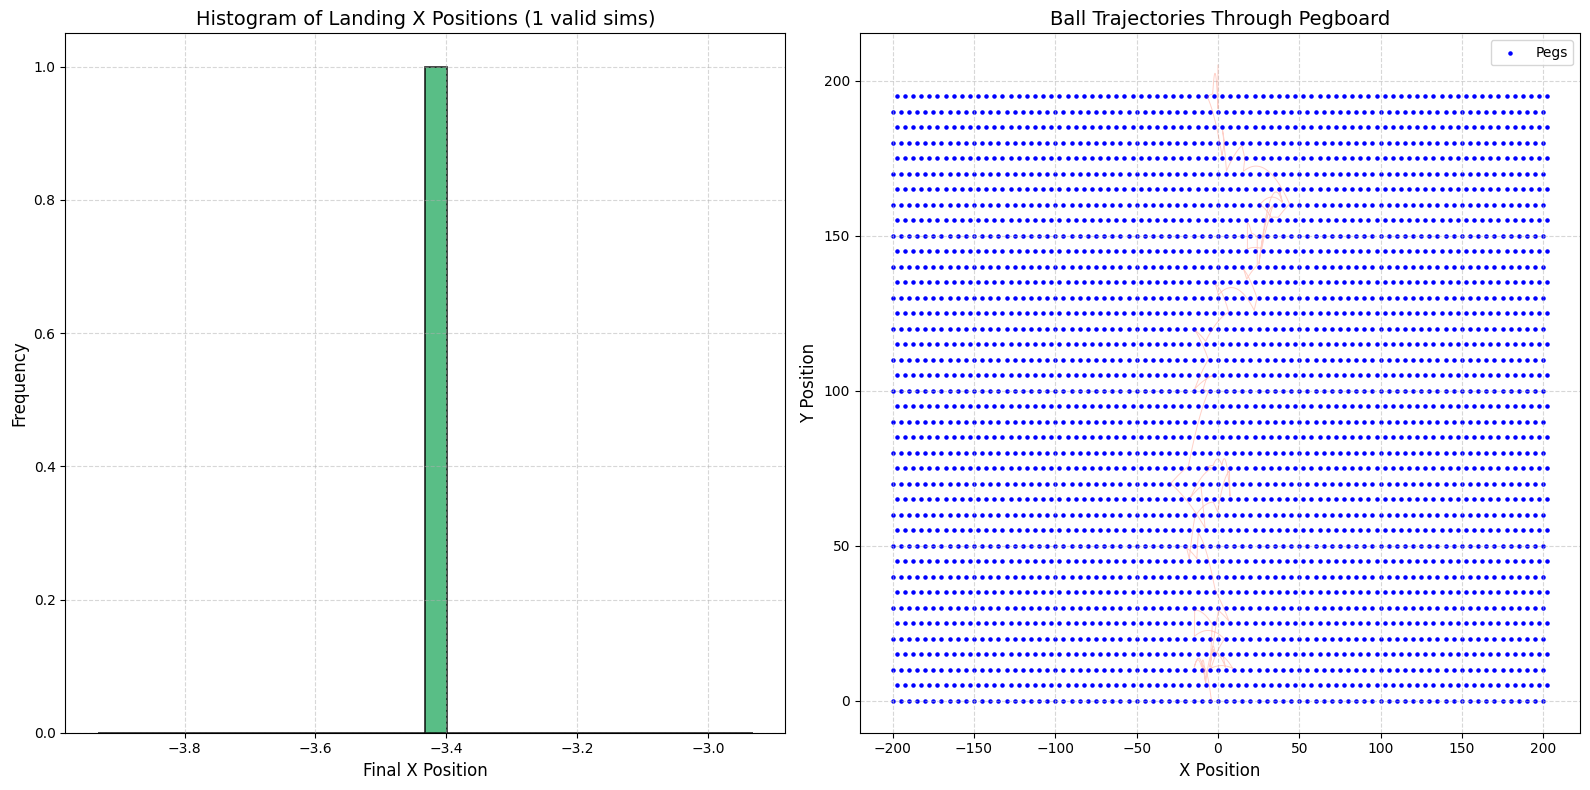

         35718859 function calls (35705537 primitive calls) in 25.092 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.105    0.105   25.092   25.092 130565722.py:1(run_multiple_simulations)
        1    0.000    0.000    0.000    0.000 130565722.py:46(<listcomp>)
        1    0.000    0.000    0.000    0.000 130565722.py:47(<listcomp>)
        1    0.000    0.000    0.000    0.000 130565722.py:52(<listcomp>)
        1    0.000    0.000    0.000    0.000 130565722.py:53(<listcomp>)
        2    0.008    0.004    0.010    0.005 3405257404.py:13(generate_pegs)
    10863   21.101    0.002   24.046    0.002 3405257404.py:28(detect_collision)
        2    0.000    0.000    0.010    0.005 3405257404.py:3(__init__)
       89    0.001    0.000    0.002    0.000 3405257404.py:40(change_momentum)
    10864    0.012    0.000    0.021    0.000 3405257404.py:80(has_hit_ground)
    10863    0.030    0.000    0.033    0.000 

In [8]:
import cProfile
cProfile.run('run_multiple_simulations(1)')


## it's the detect_collision() function, let's rewrite the function with numba and better use of arrays 

In [9]:
@njit
def detect_collision_numba(ball_x, ball_y, ball_radius, rows, cols, peg_spacing_x, peg_spacing_y):
    # Estimate which row the ball is currently above by dividing its y position
    # by the vertical spacing between peg rows, then rounding to nearest integer
    row_index = int(round(ball_y / peg_spacing_y))
    
    # If the estimated row is outside the board vertically, no collision is possible
    if row_index < 0 or row_index >= rows:
        return False, 0.0, 0.0  # Return no collision and dummy peg position
    
    # Calculate horizontal offset for the current row.
    # Pegs in every odd row are shifted half a peg spacing to the right to create a staggered pattern.
    offset_x = 0.0
    if row_index % 2 != 0:
        offset_x = peg_spacing_x / 2
    
    # Estimate which column the ball is near by adjusting for the offset and dividing
    # by peg horizontal spacing, then rounding to nearest integer
    col_index = int(round((ball_x - offset_x) / peg_spacing_x))
    
    # Check for collisions in the three closest pegs horizontally:
    # the peg directly under the ball and its immediate left and right neighbors
    for col in (col_index - 1, col_index, col_index + 1):
        # Skip if column index is outside the horizontal bounds of the pegboard
        if col < -cols // 2 or col > cols // 2:
            continue
        
        # Compute the exact peg position using column, row, spacing, and offset
        peg_x = col * peg_spacing_x + offset_x
        peg_y = row_index * peg_spacing_y
        
        # Calculate Euclidean distance from ball center to peg center
        dx = ball_x - peg_x
        dy = ball_y - peg_y
        dist = math.sqrt(dx*dx + dy*dy)
        
        # If distance is less than or equal to the ball's radius, a collision has occurred
        if dist <= ball_radius:
            return True, peg_x, peg_y
    
    # If no pegs are close enough to collide, return no collision
    return False, 0.0, 0.0



class Board:
    def __init__(self, rows, cols, peg_spacing_x, peg_spacing_y, g):
        # Gravity acceleration (unused here but stored for potential use)
        self.g = g
        
        # Number of rows and columns of pegs on the board
        self.rows = rows
        self.cols = cols
        
        # Horizontal and vertical spacing between pegs
        self.peg_spacing_x = peg_spacing_x
        self.peg_spacing_y = peg_spacing_y
        
        # Generate all peg positions once during initialization to avoid recomputing
        pegs = []
        for row in range(rows):
            # Peg rows alternate horizontal offset to create a staggered pattern:
            # even rows start aligned, odd rows shifted right by half spacing
            offset_x = 0
            if row % 2 != 0:
                offset_x = peg_spacing_x / 2
            
            # For each column in this row, compute peg position and add to list
            for col in range(-cols // 2, cols // 2 + 1):
                peg_x = col * peg_spacing_x + offset_x
                peg_y = row * peg_spacing_y
                pegs.append((peg_x, peg_y))
        
        # Store peg positions as a NumPy array of shape (number_of_pegs, 2)
        self.pegs = np.array(pegs)

    # Static method to generate peg positions without needing a Board instance
    # Useful if you want to generate pegs independently
    def generate_pegs(rows, cols, peg_spacing_x, peg_spacing_y):
        pegs = []
        for row in range(rows):
            offset_x = 0
            if row % 2 != 0:
                offset_x = peg_spacing_x / 2
            for col in range(-cols // 2, cols // 2 + 1):
                peg_x = col * peg_spacing_x + offset_x
                peg_y = row * peg_spacing_y
                pegs.append((peg_x, peg_y))
        return pegs

    def detect_collision(self, ball):
        # Get the current position of the ball
        ball_x, ball_y = ball.get_position()
        
        # Use the optimized Numba function to quickly check for collision with nearby pegs
        collided, peg_x, peg_y = detect_collision_numba(
            ball_x, ball_y, ball.radius,
            self.rows, self.cols,
            self.peg_spacing_x, self.peg_spacing_y)
        
        # Return peg position if collision detected, else None
        if collided:
            return peg_x, peg_y
        else:
            return None

    def change_momentum(self, ball, peg_x, peg_y):
        # When the ball hits a peg, it bounces off with some loss of speed and random spin
        
        damping_factor = 0.9  # Slow down velocity to simulate energy loss
        max_angle_deg = 5     # Maximum random deflection angle in degrees
        
        # Get current ball position and velocity
        ball_x, ball_y = ball.get_position()
        ball_vx, ball_vy = ball.get_velocity()
        
        # Vector from peg center to ball center
        dx = ball_x - peg_x
        dy = ball_y - peg_y
        
        # Distance between peg and ball centers
        norm = math.sqrt(dx*dx + dy*dy)
        if norm == 0:
            return  # Avoid division by zero if positions coincide exactly
        
        # Unit vector from peg to ball (direction of collision)
        unit_dx = dx / norm
        unit_dy = dy / norm
        
        # Project ball velocity along collision vector
        velocity_along_line = ball_vx * unit_dx + ball_vy * unit_dy
        
        # Only update velocity if ball is moving toward peg (velocity along line < 0)
        if velocity_along_line < 0:
            # Reflect velocity along the collision vector (elastic collision)
            ball_vx -= 2 * velocity_along_line * unit_dx
            ball_vy -= 2 * velocity_along_line * unit_dy
            
            # Apply damping to reduce speed (simulate energy loss)
            ball_vx *= damping_factor
            ball_vy *= damping_factor
            
            # Add small random rotation to velocity vector for realistic deflection
            angle_rad = math.radians(random.uniform(-max_angle_deg, max_angle_deg))
            cos_theta = math.cos(angle_rad)
            sin_theta = math.sin(angle_rad)
            
            new_vx = ball_vx * cos_theta - ball_vy * sin_theta
            new_vy = ball_vx * sin_theta + ball_vy * cos_theta
            
            # Update ball velocity with new values after collision
            ball.set_velocity(new_vx, new_vy)

    def has_hit_ground(self, ball):
        # Check if the ball has reached or passed the ground level (y <= 0)
        _, ball_y = ball.get_position()
        return ball_y <= 0

    def is_out_of_bounds(self, ball):
        # Calculate horizontal limits of the board including half peg spacing margin
        left_limit = -self.cols // 2 * self.peg_spacing_x - self.peg_spacing_x / 2
        right_limit = self.cols // 2 * self.peg_spacing_x + self.peg_spacing_x / 2
        
        # Get current x position of the ball
        ball_x, _ = ball.get_position()
        
        # Return True if ball is outside horizontal bounds of the pegboard
        return ball_x < left_limit or ball_x > right_limit



Simulating: 100%|██████████| 100/100 [00:04<00:00, 20.66it/s]


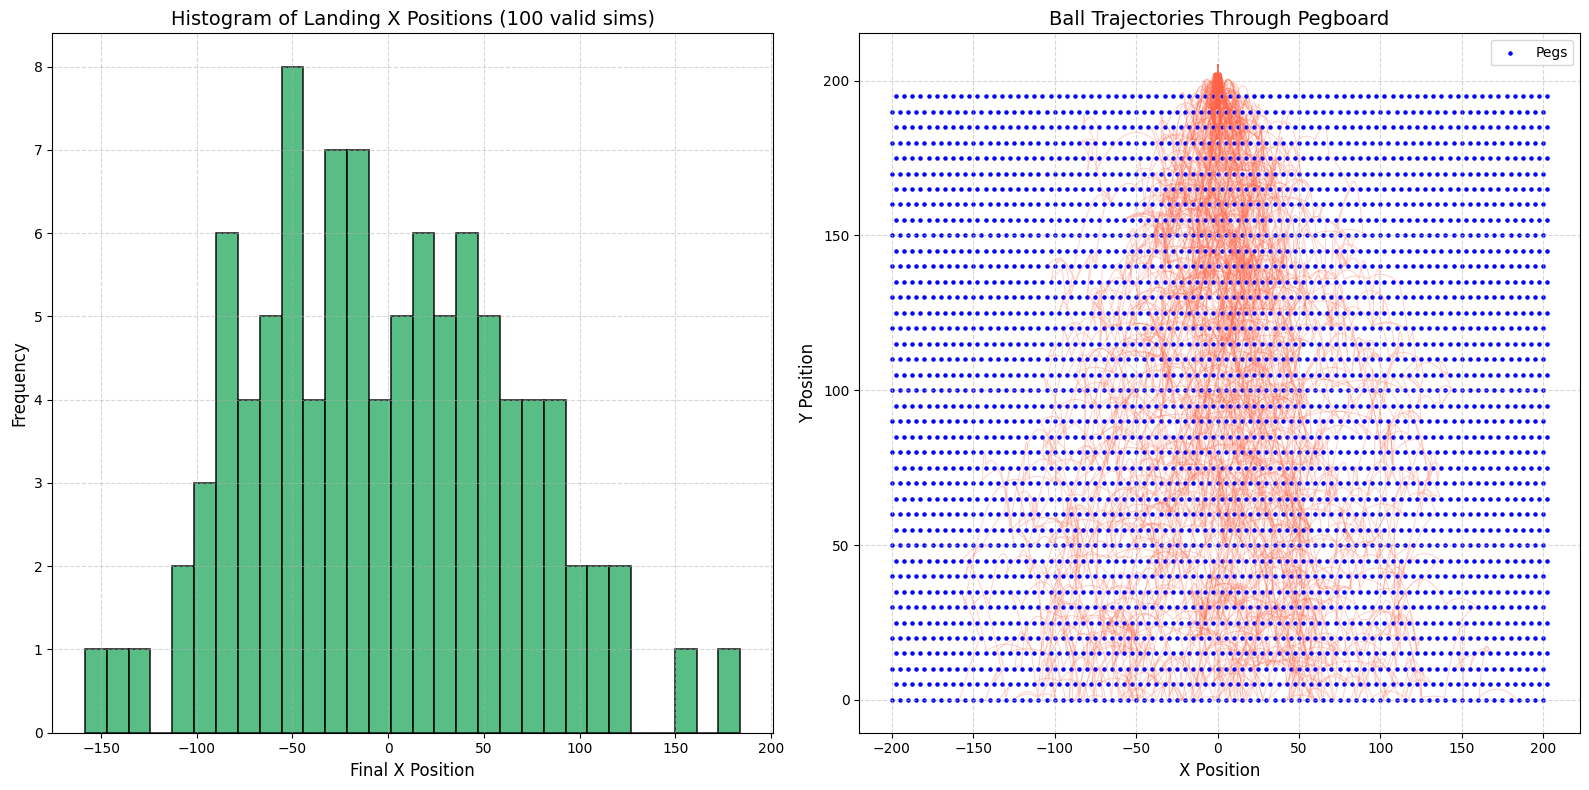

In [10]:
run_multiple_simulations(100)